# The Taxicab example

The notebook is adapted from the Kaggle competition submissions:

https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels

Note: this is a very popular topic, there many interesting kernels, 
here we consider only Python submissions, but there are some in R:

https://www.kaggle.com/yuanwxu/nyc-taxi-trip-duration-prediction

The student is encouraged to explore the ideas and techniques shown by the various submissions.


First parts: from 

https://www.kaggle.com/kartikkannapur/nyc-taxi-trips-exploratory-data-analysis


In [ ]:
# Exploratory Data Analysis - NYC Taxi Trip Duration


Kaggle Competition Link: https://www.kaggle.com/c/nyc-taxi-trip-duration/

1. [Problem Statement](#1.-Problem-Statement)
2. [Python Libraries](#2.-Python-Libraries)
3. [Datasets](#3.-Datasets)
    * 3.1. [Data Dictionary](#3.1.-Data-Dictionary)
    * 3.2. [Dataset Overview](#3.2.-Dataset-Overview)
4. [Missing Values](#4.-Missing-Values)
5. [Open-Questions/Hypothesis](#5.-Open-Questions/Hypothesis)
    * 5.1. [Difference in the columns between the training and test datasets](#5.1.-Difference-in-the-columns-between-the-training-and-test-datasets)
    * 5.2. [Are all the id's in the train and test datasets unique? Is there an overlap, in the observations, between the train and test datasets?](#5.2.-Are-all-the-id's-in-the-train-and-test-datasets-unique?-Is-there-an-overlap,-in-the-observations,-between-the-train-and-test-datasets?)
    * 5.3. [Are all the vendor_id's in the train and test datasets unique?](#5.3.-Are-all-the-vendor_id's-in-the-train-and-test-datasets-unique?)
    * 5.4. [Distribution of the number of passengers across the vendor_id variables 1 and 2, in both the train and test datasets](#5.4.-Distribution-of-the-number-of-passengers-across-the-vendor_id-variables-1-and-2,-in-both-the-train-and-test-datasets)
    * 5.5. [Distribution of the trip_duration across the train dataset](#5.5.-Distribution-of-the-trip_duration-across-the-train-dataset)
    * 5.6. [Distribution of the store_and_fwd_flag across the train dataset](#5.6.-Distribution-of-the-store_and_fwd_flag-across-the-train-dataset)
    * 5.7. [Exploring the distances between the pickup and dropoff lat/log coordinates](#5.7.-Exploring-the-distances-between-the-pickup-and-dropoff-lat/log-coordinates)
    * 5.8. [Exploring the number of trips at each timestamp feature in the train dataset](#5.8.-Exploring-the-number-of-trips-at-each-timestamp-feature-in-the-train-dataset)
    * 5.9. [Exploring the behaviour of trip_duration based on the number of trips for each timestamp feature in the train dataset](#5.9.-Exploring-the-behaviour-of-trip_duration-based-on-the-number-of-trips-for-each-timestamp-feature-in-the-train-dataset)
    
[References](#References)

## 1. Problem Statement

In this competition, the challenge is to build a model that predicts the total ride duration of taxi trips in New York City.

Feel free to provide Suggestions, Feedback and Upvotes :)

## 2. Python Libraries

In [1]:
# #Python Libraries
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels
import pandas_profiling

from sklearn import linear_model

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import time
import requests
import datetime

import missingno as msno

## 3. Datasets

In [3]:
# #Datasets
!ls DATA/t*.csv

DATA/test.csv  DATA/train.csv


In [4]:
# #Train and Test Datasets
df_train = pd.read_csv("DATA/train.csv")
df_test = pd.read_csv("DATA/test.csv")

df_sample_submission = pd.read_csv("DATA/sample_submission.csv")

### 3.1. Data Dictionary

Dataset: DATA/train.csv

* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

Dataset: DATA/test.csv

* The train dataset contains 11 columns and the test dataset contains 9 columns. The two additional columns that are present in the train dataset, and not in the test dataset are dropoff_datetime and trip_duration. 

Dataset: DATA/sample_submission.csv

* id - a unique identifier for each trip
* trip_duration - duration of the trip in seconds

### 3.2. Dataset Overview

#### Training Dataset

In [5]:
print("Total number of samples in train dataset: ", df_train.shape[0])
print("Number of columns in train dataset: ", df_train.shape[1])

Total number of samples in train dataset:  1458644
Number of columns in train dataset:  11


In [6]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


#### Test Dataset

In [9]:
print("Total number of samples in test dataset: ", df_test.shape[0])
print("Number of columns in test dataset: ", df_test.shape[1])

Total number of samples in test dataset:  625134
Number of columns in test dataset:  9


In [10]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


## 4. Missing Values

Are there any missing values in the train and test datasets?

In [11]:
df_train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [12]:
df_test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

_Fortunately, both the train and test datasets are clean & none of the values are missing._

### 5.5. Distribution of the trip_duration across the train dataset

In [13]:
# #trip_duration represents the difference between the dropoff_datetime and the pickup_datetime in the
# #train dataset
df_train["trip_duration"].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

_It is interesting to see that there happens to be a trip that lasted for over 40 days. Let us plot the trip duration in seconds to view any other possbile outliers._

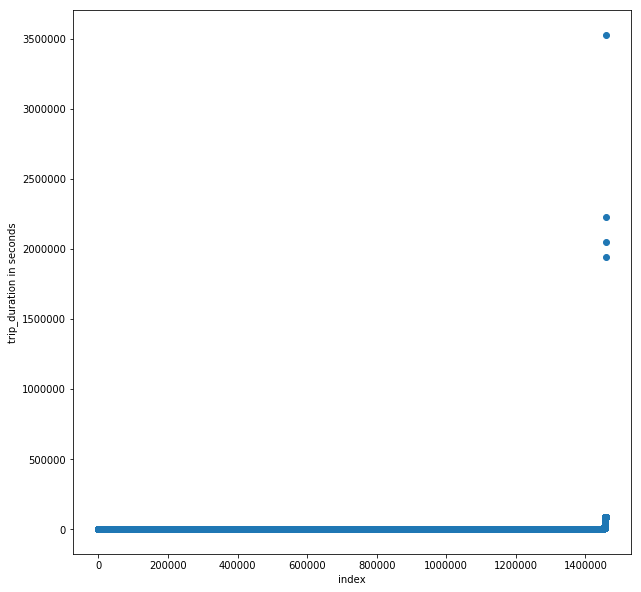

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(range(len(df_train["trip_duration"])), np.sort(df_train["trip_duration"]))
plt.xlabel('index')
plt.ylabel('trip_duration in seconds')
plt.show()

_We see that there are four outliers with trip durations of 20 days or more_

In [16]:
# #Removing the outliers in the dataset
df_train = df_train[df_train["trip_duration"] < 500000]

Further cleanup: remove trips over 2 hours

In [18]:
# #Removing the outliers in the dataset
df_train = df_train[df_train["trip_duration"] < 7200]

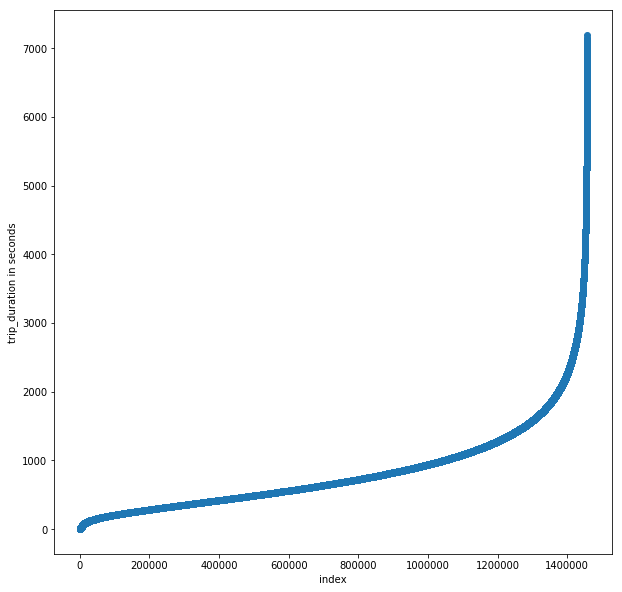

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(range(len(df_train["trip_duration"])), np.sort(df_train["trip_duration"]))
plt.xlabel('index')
plt.ylabel('trip_duration in seconds')
plt.show()

### 5.7. Exploring the distances between the pickup and dropoff lat/log coordinates

In [33]:
from haversine import haversine

In [34]:
def calculate_haversine_distance(var_row):
    return haversine((var_row["pickup_latitude"], var_row["pickup_longitude"]), 
                     (var_row["dropoff_latitude"], var_row["dropoff_longitude"]), miles = True)

In [35]:
# #Calculating the Haversine Distance
# #The haversine formula determines the great-circle distance between two points on a sphere 
# #given their longitudes and latitudes.
df_train["haversine_distance"] = df_train.apply(lambda row: calculate_haversine_distance(row), axis=1)

In [36]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,haversine_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.931137
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.121890
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,3.967515
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.923046
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.738554


In [37]:
df_train["haversine_distance"].describe()

count    1.458640e+06
mean     2.138039e+00
std      2.669720e+00
min      0.000000e+00
25%      7.654260e-01
50%      1.300971e+00
75%      2.408013e+00
max      7.710647e+02
Name: haversine_distance, dtype: float64

_Plot of the haversine distance vs the trip duration._

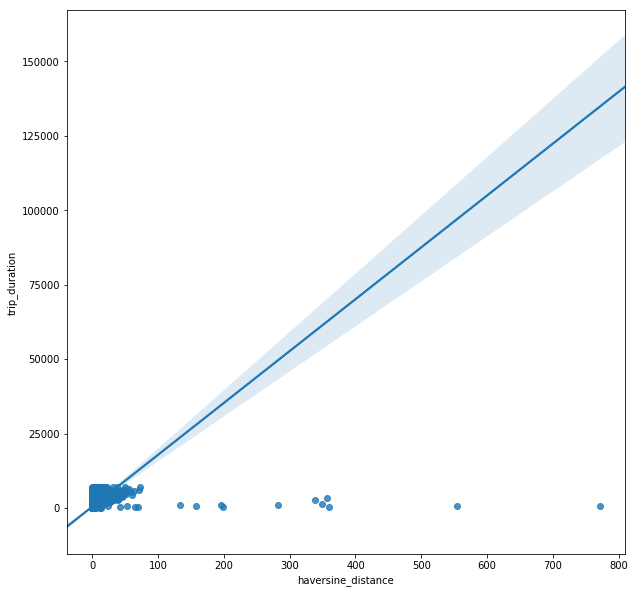

In [136]:
plt.figure(figsize=(10,10))
sns.regplot(x="haversine_distance", y="trip_duration", data=df_train)

![](http://kartikkannapur.github.io//images/haversine_distance_1.png)

_The presence of outliers in the train dataset(long tail in the haversine distance) might have caused the deviation in the regression line. It would be interesting to explore different methods for outlier detection._

In [39]:
df_train[df_train["haversine_distance"] > 100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,haversine_distance
114376,id1311087,1,2016-02-29 12:16:29,2016-02-29 18:47:09,3,-75.455917,39.803932,-73.796021,40.707726,N,23440,107.515425
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669,51.881084,-73.987228,40.750599,N,792,771.064665
275644,id0978162,1,2016-02-24 16:20:59,2016-02-24 16:35:34,4,-75.354332,34.712234,-73.834923,32.181141,N,875,195.585348
377068,id0116374,1,2016-04-02 20:33:19,2016-04-02 20:38:01,1,-74.007095,40.717113,-76.963242,38.946033,N,282,198.916873
397526,id0982904,1,2016-04-28 13:32:14,2016-04-28 14:14:09,2,-73.870682,40.773598,-79.817978,38.963852,N,2515,339.177534
644165,id0401529,2,2016-06-02 15:19:35,2016-06-02 15:32:59,1,-73.980751,40.757111,-74.240051,38.478298,N,804,158.054116
910072,id1146400,1,2016-02-15 18:57:32,2016-02-15 19:02:35,2,-73.989914,40.756634,-70.346077,36.398121,N,303,359.676140
923793,id1001696,1,2016-02-24 21:02:32,2016-02-24 21:25:57,1,-73.972366,40.758633,-79.553535,43.674000,N,1405,349.356641
974378,id1510552,2,2016-01-06 20:40:52,2016-01-06 20:51:03,5,-71.799896,35.081532,-79.352837,40.436329,N,611,553.774599
1013474,id3626673,1,2016-05-05 18:02:50,2016-05-05 18:18:23,1,-73.978912,40.756763,-79.338699,41.427902,N,933,282.873682


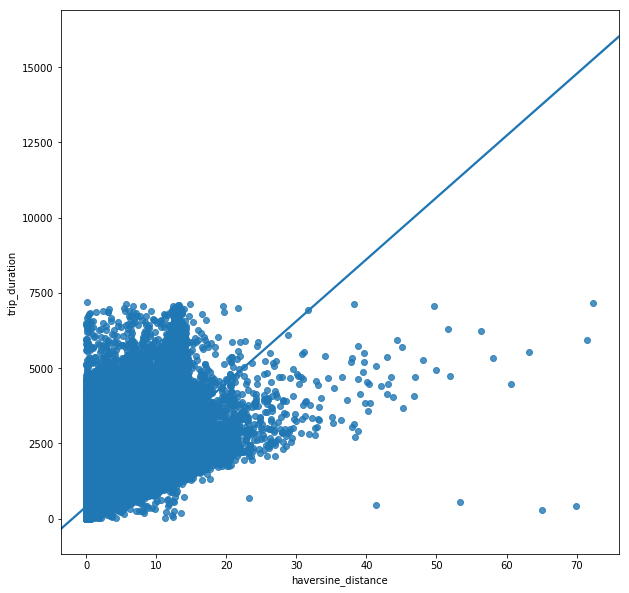

In [137]:
plt.figure(figsize=(10,10))
sns.regplot(x="haversine_distance", y="trip_duration", data=df_train[df_train["haversine_distance"] < 100])

![](http://kartikkannapur.github.io//images/haversine_distance_2.png)

In [138]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [139]:
XX = df_train[['passenger_count','haversine_distance','pickup_hour']].values
YY = df_train['trip_duration']

In [93]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(3, input_dim=3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [95]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [113]:
X = XX[:10000]
Y = YY[:10000]

In [114]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -9359772.38 (7862011.17) MSE


In [104]:
estimator.fit(X, Y)

In [109]:
Ypr = estimator.predict(X)

In [107]:
import matplotlib.pyplot as plt

In [108]:
%matplotlib inline

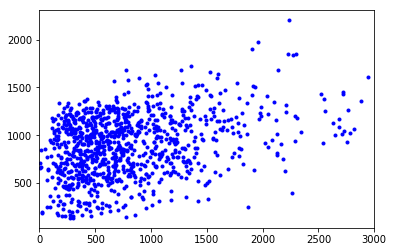

In [112]:
plt.xlim(0,3000)
plt.plot(Y,Ypr,'b.')

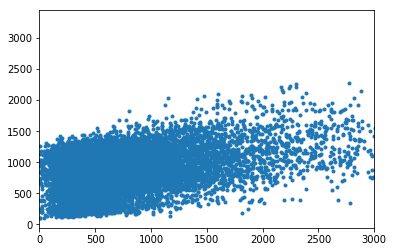

In [116]:
Ypr = estimator.predict(X)
plt.xlim(0,3000)
plt.plot(Y,Ypr,'.')